In [126]:
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import numpy as np
from datetime import date
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_theme()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import plotly.express as px
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller 

In [127]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [160]:
df=pd.read_csv("dfdaily.csv")

In [161]:
df=df.set_index("date")

In [130]:
df.head()

,Value
date,
2016-03-01,579.0
2016-03-02,476.0
2016-03-03,510.0
2016-03-04,544.0
2016-03-05,634.0


In [131]:
def snscount(att,title, rot=0,font=15):
    '''
    count plots
    '''
    sns.countplot(att)
    plt.title(title,loc="center")
    plt.xticks(rotation=rot)
    plt.xticks(fontsize=font)
    plt.show()

In [84]:
def apacf(df,lag):
    '''
    plot acf pacf 
    '''
    fig=plot_acf(df,lags=lag)
    fig=plot_pacf(df,lags=lag)
  

    
def adftest(df,reg):
    '''
    Unit root test
    '''
    adftest=adfuller(df,regression=reg,autolag="AIC")
    print("ADF: ", adftest[0])
    print("P-value: " ,adftest[1])
    print("Number of lags: ", adftest[2])
    print("number of obs.",adftest[3])
    print("critical Values: ", adftest[4])    
    
def estimate(p,q,ps,qs,d,ds):
    '''
    Calculate RMSE for a given model
    '''
    model = pm.ARIMA(order=(p,d,q), seasonal_order=(ps,ds,qs,7),suppress_warnings=True)
    model.fit(train)
    fc=model.predict(n_periods=m,return_conf_int=True)
    pred_df=pd.DataFrame(fc[0],index=test.index,columns=["Forecast"])
    new=pred_df.join(test)
    rmse=((new.Forecast-new.Value)**2).sum()**0.5    
    return (round(rmse,2))    


def pred(p,q,ps,qs,d,ds):
    '''
    Get predictions for a model 
    '''
    model = pm.ARIMA(order=(p,d,q), seasonal_order=(ps,ds,qs,7),suppress_warnings=True)
    model.fit(train)
    fc=model.predict(n_periods=m,return_conf_int=True)
    pred_df=pd.DataFrame(fc[0],index=test.index,columns=["Forecast"])
    pred_df["lower"]=fc[1][:,0]
    pred_df["upper"]=fc[1][:,1]
    return(pred_df)

def forecast(p,q,ps,qs,d,ds):
    
    '''
    Forecast for next 14 days
    '''
    model = pm.ARIMA(order=(p,d,q), seasonal_order=(ps,ds,qs,7),suppress_warnings=True)
    model.fit(train)
    print(model.summary())
    fc=model.predict(n_periods=m+14,return_conf_int=True)
    forecast=pd.DataFrame(fc[0],columns=["forecast"])
    forecast["lower"]=fc[1][:,0]
    forecast["upper"]=fc[1][:,1]
    return(forecast)


def tsplot(df):
    '''
    plot time series
    '''
    fig, ax = plt.subplots(figsize=(18,10))
    ax.plot(df.date,df.Value,color='g',label="original")
    ax.plot(df.date,df.Forecast,color='b',label="fit")
    ax.fill_between(df.date,df.lower,df.upper,alpha=0.8,color='b')
    ax.set_xlabel("Date")
    ax.legend()
    ax.grid()

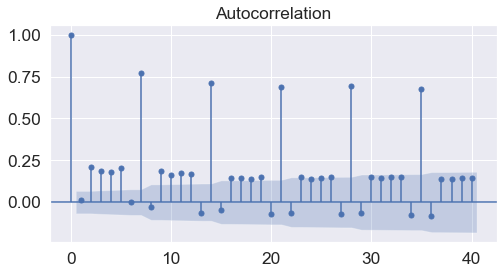

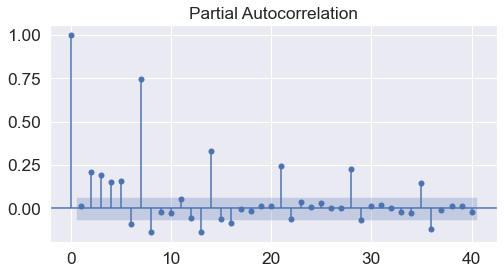

In [85]:
apacf(df.Value,40)

In [86]:
adftest(df.Value,"ct")

ADF:  -3.429753988606018
P-value:  0.04753768163364461
Number of lags:  21
number of obs. 830
critical Values:  {'1%': -3.969718849807708, '5%': -3.4157928344715773, '10%': -3.130170917352091}


## d=0

In [87]:
df1=df.diff(7).dropna()

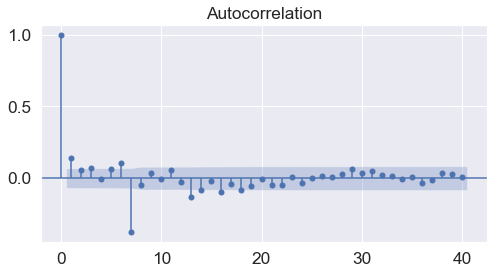

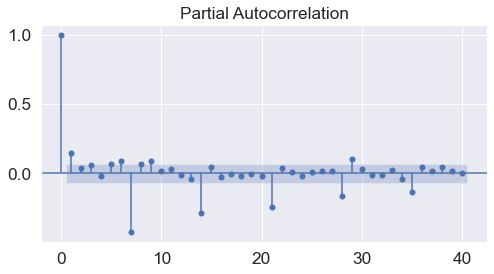

In [88]:
apacf(df1.Value,40)

This fixes: Q=2, q=1,d=0,D=1

In [132]:
train=df[["Value"]][:800]
test=df[["Value"]][800:]
m=len(test)

In [133]:
model1=estimate(0,1,0,2,0,1)
model1

434.71

In [135]:
err=[]
for p in [0,1]:
    for ps in [0,1]:
        for qs in [1,2]:
            err.append([p,ps,qs,estimate(p,1,ps,qs,0,1)])

In [ ]:
errdf=pd.DataFrame(err,columns=["p","ps","qs","RMSE"])

In [93]:
errdf.sort_values("RMSE")

,p,ps,qs,RMSE
5,1,0,2,371.37
6,1,1,1,371.62
4,1,0,1,375.29
7,1,1,2,376.79
3,0,1,2,394.44
2,0,1,1,433.22
1,0,0,2,434.71
0,0,0,1,445.17


In [94]:
dfpred=pred(1,1,0,2,0,1)

In [95]:
dfpred=df.join(dfpred).reset_index()
dfpred.date=pd.to_datetime(dfpred.date)

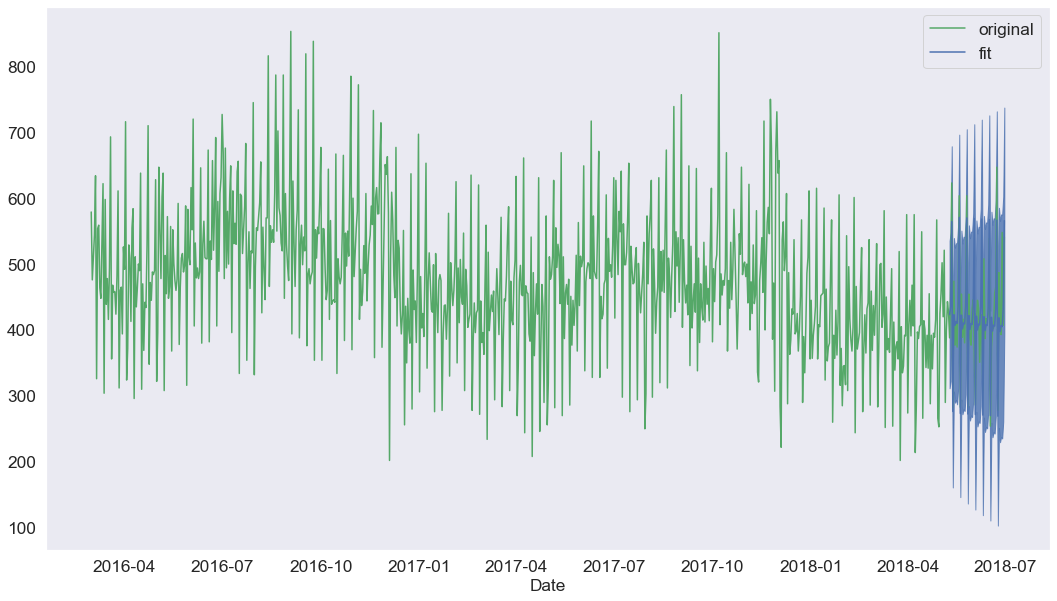

In [96]:
tsplot(dfpred)

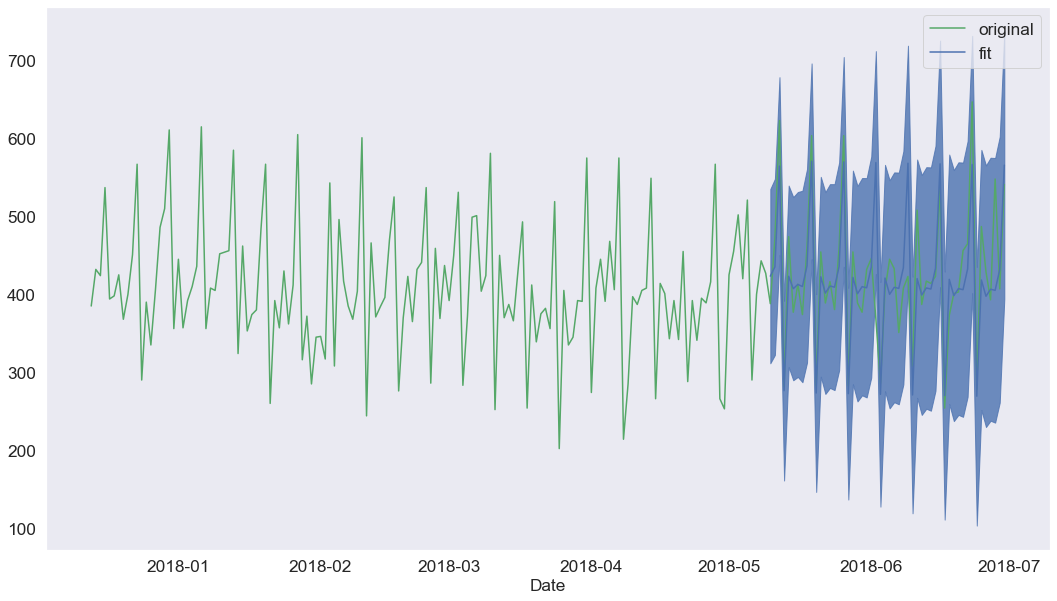

In [97]:
tsplot(dfpred[-200:])

## d=1

In [98]:
df2=df.diff().dropna()

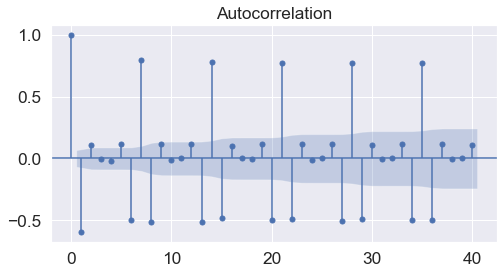

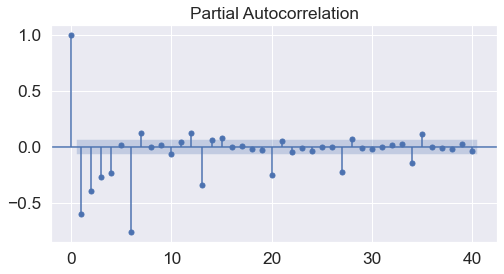

In [99]:
apacf(df2.Value,40)

This fixes: Q=2, q=4,d=1,D=0

In [100]:
train=df[["Value"]][:800]
test=df[["Value"]][800:]
m=len(test)

In [101]:
model2=estimate(0,4,0,2,1,0)
model2

604.3

In [102]:
err=[]
for p in [0,1]:
    for ps in [0,1]:
        for qs in [1,2]:
            for q in [3,4]:
                err.append([p,q,ps,qs,estimate(p,q,ps,qs,1,0)])

In [103]:
errdf=pd.DataFrame(err,columns=["p","q","ps","qs","RMSE"])

In [104]:
errdf.sort_values("RMSE").head(2)

,p,q,ps,qs,RMSE
14,1,3,1,2,364.51
15,1,4,1,2,373.88


In [105]:
dfpred=pred(1,3,1,1,1,0)

In [106]:
dfpred=df.join(dfpred).reset_index()
dfpred.date=pd.to_datetime(dfpred.date)

In [107]:
# def tsplot(df):
#     fig, ax = plt.subplots(figsize=(18,10))
#     ax.plot(df.date,df.Value,color='g',label="original")
#     ax.plot(df.date,df.Forecast,color='b',label="fit")
#     ax.fill_between(df.date,df.lower,df.upper,alpha=0.8,color='b')
#     ax.set_xlabel("Date")
#     ax.legend()
#     ax.grid()


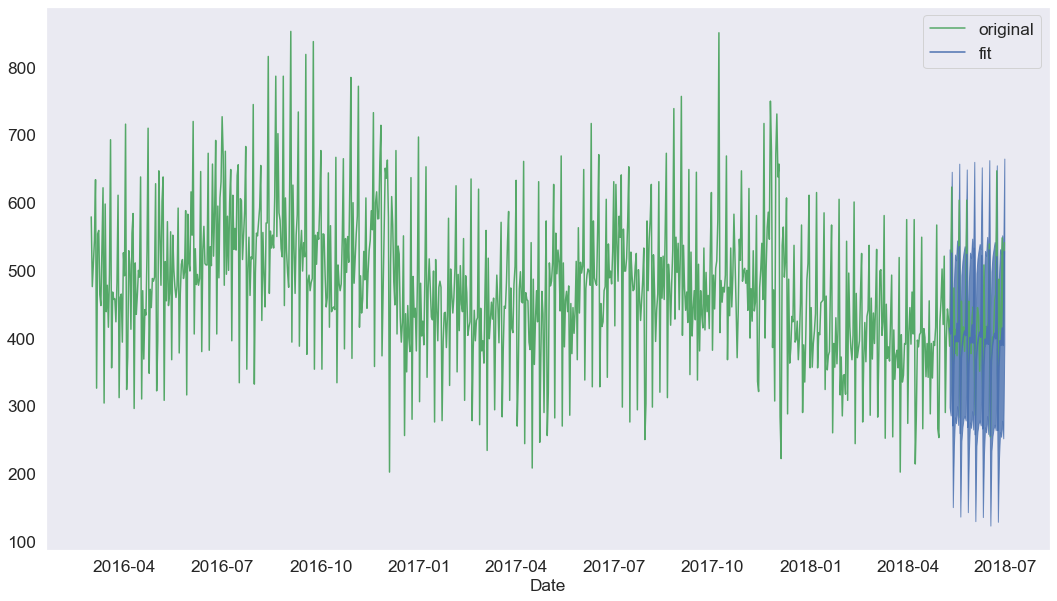

In [108]:
tsplot(dfpred)

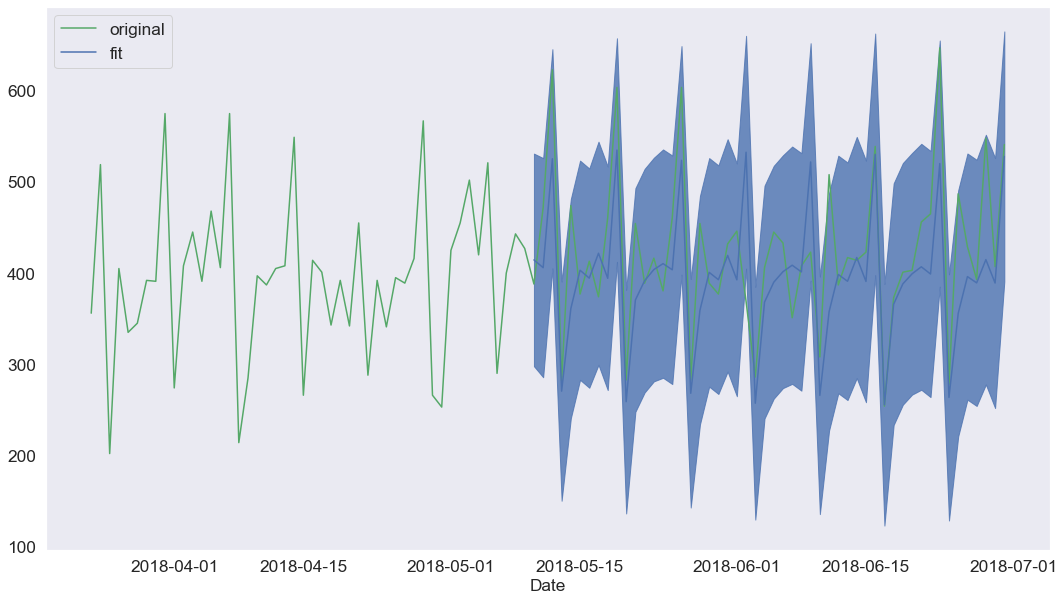

In [109]:
tsplot(dfpred[-100:])

In [110]:
# def forecast(p,q,ps,qs,d,ds):
    
#     '''
#     Forecast for next 14 days
#     '''
#     model = pm.ARIMA(order=(p,d,q), seasonal_order=(ps,ds,qs,7),suppress_warnings=True)
#     model.fit(train)
#     print(model.summary())
#     fc=model.predict(n_periods=m+14,return_conf_int=True)
#     forecast=pd.DataFrame(fc[0],columns=["forecast"])
#     forecast["lower"]=fc[1][:,0]
#     forecast["upper"]=fc[1][:,1]
#     return(forecast)




### Final model: (1,0,1) X (0,1,2)_7

In [136]:
fc=forecast(1,1,0,2,0,1)

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  800
Model:             SARIMAX(1, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -4341.599
Date:                                Mon, 12 Sep 2022   AIC                           8695.199
Time:                                        19:37:04   BIC                           8723.254
Sample:                                    03-01-2016   HQIC                          8705.981
                                         - 05-09-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0012      0.010     -0.124      0.901      -0.021       0.018
ar.

In [137]:
idx=pd.date_range(start=df.index[0],end=fc.index[-1],freq="d")
#data1=data.set_index(pd.DatetimeIndex(data['dateTime'])).drop(columns={"dateTime"})

In [138]:
df

,Value
date,
2016-03-01,579.0
2016-03-02,476.0
2016-03-03,510.0
2016-03-04,544.0
2016-03-05,634.0
...,...
2018-06-26,429.0
2018-06-27,393.0
2018-06-28,548.0


In [162]:
df=df.reset_index()
df.date=pd.to_datetime(df.date)

In [164]:
df=df.set_index(pd.DatetimeIndex(df['date'])).drop(columns={"date"})
df=df.reindex(idx)
df=df.join(fc)
df=df.reset_index().rename(columns={"index":"date"})

[]

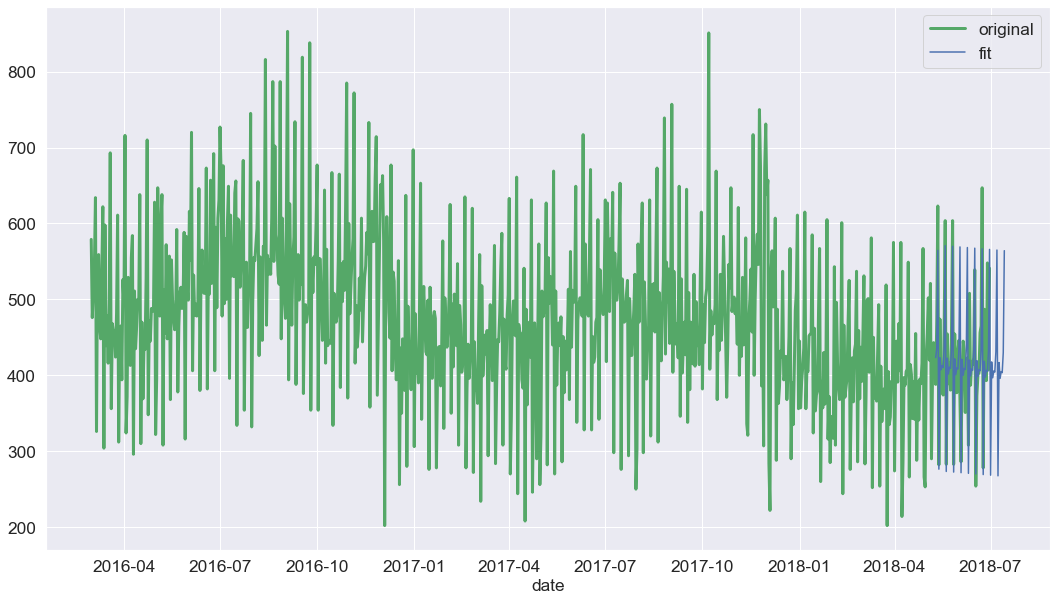

In [173]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(df.date,df.Value,color='g',label="original",linewidth=3)
ax.plot(df.date,df.forecast,color='b',label="fit")
#ax.fill_between(df.date,df.lower,df.upper,alpha=0.8,color='b')
ax.set_xlabel("date")
ax.legend()
ax.plot()


In [174]:
df=df[-100:]

[]

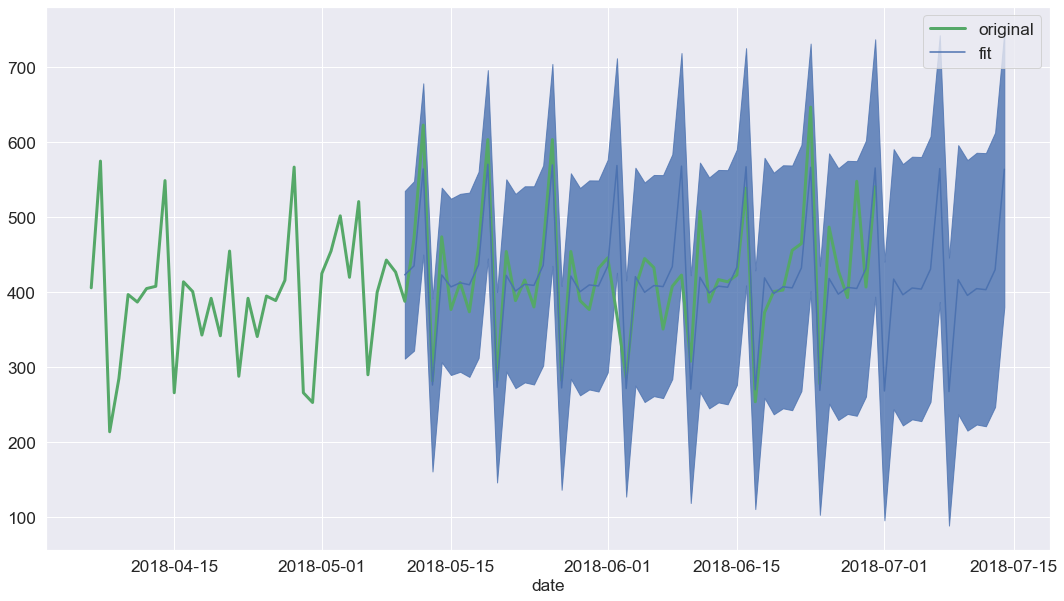

In [176]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(df.date,df.Value,color='g',label="original",linewidth=3)
ax.plot(df.date,df.forecast,color='b',label="fit")
ax.fill_between(df.date,df.lower,df.upper,alpha=0.8,color='b')
ax.set_xlabel("date")
ax.legend()
ax.plot()

In [177]:
fc[-14:]

,forecast,lower,upper
2018-07-01,268.378522,95.847806,440.909237
2018-07-02,417.600766,244.184387,591.017146
2018-07-03,396.721072,222.432093,571.010050
2018-07-04,405.716980,230.558884,580.875077
2018-07-05,404.310915,228.178479,580.443352
2018-07-06,430.909613,253.909040,607.910185
2018-07-07,565.000682,387.140199,742.861164
2018-07-08,267.555741,88.843449,446.268033
2018-07-09,416.777945,237.221822,596.334069
2018-07-10,395.898210,215.510718,576.285702
